## AIM: Fine-tune pretrained ShallowNet as multiclass classification model for predicting the psychiatric diagnosis based on SSL features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
import os
from sklearn.model_selection import StratifiedGroupKFold
import contextlib
import io

import optuna

import torch.nn as nn
from lightning.pytorch.loggers import CSVLogger
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
from torch.utils.data import Dataset, DataLoader, Subset
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

## Functions:

In [2]:
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)
# functions for loading the epoched EEG data
def get_filepath(epoch_dir, participant_ids):
    """
    Function to get the filepath of the epoched EEG recording
    :param epoch_dir: directory containing the epoched EEG recordings
    :param participant_ids: list of participant IDs to include
    """
    filepaths = []
    found_ids = set()
    
    for subdir, dirs, files in os.walk(epoch_dir):
        for file in files:
            for participant_id in participant_ids:
                if participant_id in file:
                    filepaths.append(os.path.join(subdir, file))
                    found_ids.add(participant_id)
    
    # Print participant IDs if no files matching those IDs are found
    for participant_id in participant_ids:
        if participant_id not in found_ids:
            print(f"No files found for participant ID {participant_id}")

    return filepaths

class EpochDataset(torch.utils.data.Dataset):
    def __init__(self, participant_ids, epoch_dir, df_classes):
        self.filepaths = get_filepath(epoch_dir, participant_ids)
        self.epochs = []
        self.participant_ids = []
        self.diagnosis = []
        self.df_classes = df_classes
        self._load_data()
        assert len(self.epochs) == len(self.participant_ids) == len(self.diagnosis)
        print(f"Loaded {len(self.epochs)} epochs")

    def _load_data(self):
        all_epochs = []
        for filepath in self.filepaths:
            epochs = torch.load(filepath, weights_only=False)
            # get participant ID from filepath to make sure the participant ID is correct
            participant_id = filepath.split("/")[-1].split(".")[0]
            # print(f'{participant_id = }')
            # get the diagnosis of the participant
            diagnosis = self.df_classes[self.df_classes["participants_ID"] == participant_id]["labels"].values[0]

            all_epochs.append(epochs)
            self.participant_ids.extend([participant_id]*epochs.shape[0])
            self.diagnosis.extend([diagnosis]*epochs.shape[0])

        self.epochs = np.concatenate(all_epochs, axis=0)

    def __len__(self):
        return self.epochs.shape[0]
    
    def __getitem__(self, idx):
        epoch = self.epochs[idx]
        y = self.diagnosis[idx]
        participant_id = self.participant_ids[idx]
        return torch.tensor(epoch, dtype=torch.float32), y, participant_id
    
def transfer_freeze_weights(pretrained_weights, model, freeze=True):
            """
            Function to transfer the pretrained weights to the downstream model
            param: pretrained_weights: the weights to transfer in a dictionary
            param: model: the model to transfer the weights to
            param: freeze: whether to freeze the pretrained weights or not
            """
            pretrained_model = model
            modified_keys = {}
            for k, v in pretrained_weights.items():
                decomposed_key = k.split('.')
                if decomposed_key[0] == 'EEGNet' or decomposed_key[0] == 'ShallowNet': # remove the first part of each key to match the model's keys
                    pretrained_key = '.'.join(decomposed_key[1:])
                    modified_keys[pretrained_key] = v

            pretrained_model.load_state_dict(modified_keys, strict=False)
            if freeze: # freeze only the layers that have been pretrained
                for name, param in pretrained_model.named_parameters():
                    if name in modified_keys.keys():
                        # print(f'Freezing layer: {name}')
                        param.requires_grad = False
            return pretrained_model

def evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path):
    """
    Function to evaluate the best model based on the test scores
    :param test_scores: the test scores for each fold
    :param best_outer_hyperparameters: the best hyperparameters for each fold
    """
    best_fold = np.argmax(test_scores)
    best_params = best_outer_hyperparameters[best_fold]
    print(f'Best fold: {best_fold}')
    print(f'Best hyperparameters: {best_params}')
    print(f'Best test f1-score: {test_scores[best_fold]}')

    # load the best model
    fc_layers=best_params['fc_layers']
    dropout=best_params['dropout']
    optimizer_name=best_params['optimizer']
    learning_rate=best_params['learning_rate']

    best_model_path = os.path.join(checkpoints_path, f'fold-{best_fold}-last.ckpt')
    print(f"Best model checkpoint path: {best_model_path}")
    best_model = ShallowNet.load_from_checkpoint(
        checkpoint_path=best_model_path,
        fc_layers=fc_layers,
        dropout=dropout,
        optimizer_name=optimizer_name,
        learning_rate=learning_rate,
    )

    # print training curve
    curve_path = os.path.join(checkpoints_path[:-len('checkpoints')], 'metrics.csv')
    print(f"Training curve path: {curve_path}")
    curve = pd.read_csv(curve_path)

    # Extract the indices for the best fold
    # Assuming each fold has a unique range of steps
    fold_size = curve['epoch'].max()
    start_index = best_fold * (fold_size * 2) + ((best_fold+1) * 1) - 1 # Each epoch has two entries (train and val)
    end_index = start_index + (fold_size * 2)
    indices_from_best_fold = curve.iloc[start_index:end_index]
    # print(start_index, end_index)
    # print(indices_from_best_fold)

    # Filter out the test metrics
    train_indices = indices_from_best_fold[indices_from_best_fold['train_loss'].notna()]
    val_indices = indices_from_best_fold[indices_from_best_fold['val_loss'].notna()]

    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the F1 score in the first subplot
    axes[0].plot(train_indices['epoch'], train_indices['train_f1'], label='Train F1')
    axes[0].plot(val_indices['epoch'], val_indices['val_f1'], label='Validation F1')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('F1 Score')
    axes[0].set_title('F1 Score for Best Fold')
    axes[0].legend()
    axes[0].grid(True)

    # Plot the loss in the second subplot
    axes[1].plot(train_indices['epoch'], train_indices['train_loss'], label='Train Loss')
    axes[1].plot(val_indices['epoch'], val_indices['val_loss'], label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss for Best Fold')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()



    # obtain classification report and confusion matrix on all data
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
    y_hat = trainer.predict(best_model, dataloaders=dataloader)
    y_true = np.array(dataset.diagnosis)
    y_hat = np.concatenate(y_hat).flatten()
    print(y_hat.shape)
    print(classification_report(y_true, y_hat, target_names=le.classes_))
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first confusion matrix
    cm = confusion_matrix(y_true, y_hat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues', values_format='d', colorbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Plot the normalized confusion matrix
    cm_norm = confusion_matrix(y_true, y_hat, normalize='true')
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le.classes_)
    disp_norm.plot(cmap='Blues', colorbar=False, ax=axes[1])
    axes[1].set_title('Normalized Confusion Matrix')
    axes[1].grid(False)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    return

In [3]:
def nested_cv_optuna(n_epochs, n_trials, dataset, labels, groups, pretrained_weights):
    '''	
    Function to perform nested cross-validation with hyperparameter optimization for ShallowNet using Optuna
    :param n_epochs: number of epochs to train the model
    :param n_trials: number of trials for the hyperparameter optimization
    :param dataset: the dataset containing the EEG epochs
    :param labels: the labels of the dataset
    :param groups: the participant IDs of the dataset
    :param pretrained_weights: the pretrained weights to transfer to the model
    :return: the test scores and the best hyperparameters for each fold
    '''
    outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
    test_scores = []
    best_outer_hyperparameters = {}
    logger = CSVLogger("logs", name='ShallowNetTest') # log results to csv file
    torch.set_float32_matmul_precision('high') # for use of tensor cores
    for i, (train_val_idx, test_idx) in enumerate(outer_cv.split(dataset, labels, groups)):
        # print(f'Size of train/val set: {len(train_val_idx)}')
        # print(f'Size of test set: {len(test_idx)}')
        train_val_set = Subset(dataset, train_val_idx)
        test_set = Subset(dataset, test_idx)
        
        # inner cv
        def objective_cv(trial):
            # suggest values for the hyperparameters
            learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
            fc_layers = trial.suggest_int('fc_layers', 1, 5)
            optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
            batch_size = trial.suggest_categorical('batch_size', [50, 100, 178, 350, 476, 700])
            dropout = trial.suggest_float('dropout', 0, 0.8)
            hyperparameters = dict(learning_rate=learning_rate, fc_layers=fc_layers, optimizer_name=optimizer_name,
                                batch_size=batch_size, dropout=dropout)
            
            # n_epochs = batch_size * 4 # vary training epochs based on batch size

            # create the model
            model = ShallowNet(fc_layers=fc_layers, dropout=dropout, optimizer_name=optimizer_name, learning_rate=learning_rate)

            pretrained_model = transfer_freeze_weights(pretrained_weights, model, freeze=True)
            
            # inner cv
            inner_cv = StratifiedGroupKFold(n_splits=3, shuffle=False)
            val_scores = []
            for j, (train_idx, val_idx) in enumerate(inner_cv.split(train_val_set, labels[train_val_idx], groups[train_val_idx])):
                # print(f'Size of train set: {len(train_idx)}')
                # print(f'Size of val set: {len(val_idx)}')
                train_set = Subset(train_val_set, train_idx)
                val_set = Subset(train_val_set, val_idx)
                # Redirect both stdout and stderr (Suggested by GitHub Copilot to suppress output)
                with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                    trainer = Trainer(
                        accelerator='gpu',
                        devices=1,
                        max_epochs=n_epochs,
                        enable_progress_bar=False,  # Disable progress bar
                        enable_model_summary=False,
                        logger=False,  # Disable logging
                        enable_checkpointing=False,
                    )

                    # Train model
                    trainer.fit(pretrained_model, train_dataloaders=DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True),
                                val_dataloaders=DataLoader(val_set, batch_size=batch_size, shuffle=False))

                    # Evaluate the model on the validation set
                    val_result = trainer.validate(pretrained_model, dataloaders=DataLoader(val_set, batch_size=len(val_set), shuffle=False))
                # print(val_result)
                val_scores.append(val_result[0]['val_f1'])  # Optimizing based on validation f1-score
            
            # return the average validation score
            avg_val_f1 = np.mean(val_scores)
            return avg_val_f1

        study = optuna.create_study(direction='maximize')
        study.optimize(objective_cv, n_trials=n_trials)

        # print(f'Best hyperparameters for fold {i}: {study.best_params}')
        best_outer_hyperparameters[i] = study.best_params

        # train the best inner model on the entire train/val set with the best hyperparameters
        best_params = study.best_params
        final_model = ShallowNet(
            fc_layers=best_params['fc_layers'],
            dropout=best_params['dropout'],
            optimizer_name=best_params['optimizer'],
            learning_rate=best_params['learning_rate']
        )

        pretrained_final_model = transfer_freeze_weights(pretrained_weights, final_model, freeze=True)
        
        # Define the checkpoint callback with the fold number in the filename
        fully_trained_callback = ModelCheckpoint(
            filename=f'fold-{i}-last'
        )

        final_trainer = Trainer(
            accelerator='gpu',
            devices=1,
            max_epochs=n_epochs,
            enable_progress_bar=False,
            enable_model_summary=False,
            logger=logger,
            enable_checkpointing=True,
            callbacks=[fully_trained_callback],
        )
        final_trainer.fit(
            pretrained_final_model,
            train_dataloaders=DataLoader(train_val_set, batch_size=best_params['batch_size'], shuffle=True), # maybe drop_last=True??
            val_dataloaders=DataLoader(test_set, batch_size=best_params['batch_size'], shuffle=False)
        )

        # evaluate the model on the test set
        test_result = final_trainer.test(pretrained_final_model, dataloaders=DataLoader(test_set, batch_size=len(test_set), shuffle=False))
        print(f'Test result for fold {i}: {test_result}')
        test_scores.append(test_result[0]['test_f1'])
    
    return test_scores, best_outer_hyperparameters, fully_trained_callback.dirpath

In [4]:
def pipeline_tuning(n_epochs, n_trials, dataset, pretext_task, weights_dir=r'current_pretext_model_weights'):
    '''
    Function to perform the pipeline for hyperparameter tuning
    :param n_epochs: number of epochs to train the model
    :param n_trials: number of trials for the hyperparameter optimization
    :param dataset: the dataset containing the EEG epochs
    :param: pretext_task: a string indicating the specific pretext task to load the weights from
    :param weights_dir: the directory containing the pretrained weights
    '''
    labels = np.array(dataset.diagnosis)
    groups = np.array(dataset.participant_ids)
    pretrained_weights = torch.load(f'{weights_dir}/{pretext_task}_weights.pt')
    test_scores, best_outer_hyperparameters, checkpoints_path = nested_cv_optuna(n_epochs, n_trials, dataset, labels, groups, pretrained_weights)
    return test_scores, best_outer_hyperparameters, checkpoints_path

## ShallowNet Architecture

In [5]:
class ShallowNet(pl.LightningModule):
        """
        Pytorch implementation of the ShallowNet Encoder.
        Code taken and adjusted from:
        https://github.com/MedMaxLab/selfEEG/blob/024402ba4bde95051d86ab2524cc71105bfd5c25/selfeeg/models/zoo.py#L693
        """

        def __init__(self,
                    fc_layers, # number of fully connected layers
                    learning_rate, # learning rate
                    optimizer_name, # optimizer
                    dropout, # dropout probability
                    num_classes=5, # number of classes in the dataset
                    samples=1244,
                    chans=26, # number of EEG channels
                    F=40, # number of output filters in the temporal convolution layer
                    K1=25, # length of the temporal convolutional layer
                    pool=75, # temporal pooling kernel size
                    num_extracted_features=100, # number of features to extract
                    ):
            super(ShallowNet, self).__init__()
            self.learning_rate = learning_rate
            self.optimizer_name = optimizer_name

            self.conv1 = nn.Conv2d(1, F, (1, K1), stride=(1, 1))
            self.conv2 = nn.Conv2d(F, F, (chans, 1), stride=(1, 1))
            self.batch1 = nn.BatchNorm2d(F)
            self.pool2 = nn.AvgPool2d((1, pool), stride=(1, 15))
            self.flatten2 = nn.Flatten()
            self.drop1 = nn.Dropout(0.2)
            self.lin = nn.Linear(
                F * ((samples - K1 + 1 - pool) // 15 + 1), num_extracted_features
            )

            # part for downstream task
            self.batch2 = nn.BatchNorm1d(num_extracted_features)
            self.fcs = ModuleList()
            self.dropouts = ModuleList()
            input_size = num_extracted_features # Input size for the first layer
            output_size = num_classes # Output size for the last layer
            sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
            for i in range(fc_layers): # Create the layers
                self.fcs.append(Linear(sizes[i], sizes[i + 1]))
                if i < fc_layers - 1:  # Append dropout only if it's not the last layer
                    self.dropouts.append(Dropout(p=dropout))

            # add metrics
            self.train_f1 = F1Score(task='multiclass', num_classes=5, average='macro')
            self.val_f1 = F1Score(task='multiclass', num_classes=5, average='macro')

        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.batch1(x)
            x = torch.square(x)
            x = self.pool2(x)
            x = torch.log(torch.clamp(x, 1e-7, 10000))
            x = self.flatten2(x)
            x = self.drop1(x)
            x = self.lin(x) # These are the SSL features
            x = self.batch2(x) # Standardize the features
            for i, fc in enumerate(self.fcs):
                if i < len(self.fcs) - 1:  # Apply relu only if it's not the last layer
                    x = F.relu(fc(x))
                    x = self.dropouts[i](x)
                else:
                    x = fc(x) # Apply the last layer without relu & no dropout

            return x
        
        def configure_optimizers(self):
            if self.optimizer_name == 'Adam':
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
            elif self.optimizer_name == 'RMSprop':
                optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
            elif self.optimizer_name == 'SGD':
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
            else:
                raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
            return optimizer
        
        def training_step(self, train_batch, batch_idx):
            x = train_batch[0]
            y = train_batch[1]
            x = x.unsqueeze(1)
            y = y.long()
            logits = self.forward(x)
            loss = F.cross_entropy(logits, y)
            y_hat = torch.argmax(logits, dim=1)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True, on_step=False)
            self.log('train_f1', self.train_f1(y_hat, y), on_epoch=True, prog_bar=True, on_step=False)
            return loss
        
        def validation_step(self, val_batch, batch_idx):
            x = val_batch[0]
            y = val_batch[1]
            x = x.unsqueeze(1)
            y = y.long()
            logits = self.forward(x)
            loss = F.cross_entropy(logits, y)
            y_hat = torch.argmax(logits, dim=1)
            self.log('val_loss', loss, on_epoch=True, prog_bar=True)
            self.log('val_f1', self.val_f1(y_hat, y), on_epoch=True, prog_bar=True)
            return loss
        
        def test_step(self, test_batch, batch_idx):
            x = test_batch[0]
            y = test_batch[1]
            x = x.unsqueeze(1)
            y = y.long()
            logits = self.forward(x)
            loss = F.cross_entropy(logits, y)
            y_hat = torch.argmax(logits, dim=1)
            self.log('test_loss', loss, on_epoch=True, prog_bar=True)
            self.log('test_f1', self.val_f1(y_hat, y), on_epoch=True, prog_bar=True)
            return loss
        
        def predict_step(self, batch):
            x = batch[0]
            x = x.unsqueeze(1)
            logits = self.forward(x)
            y_hat = torch.argmax(logits, dim=1)
            return y_hat

## Loading data

In [6]:

df_participants = pd.read_pickle(r'df_participants.pkl')
sample_df = pd.read_pickle(r'df_selected_stat_features.pkl')
sample_ids = sample_df['ID'].unique() # obtain unique IDs from subsampled dataframe containing epoched features
df_sample = df_participants[df_participants['participants_ID'].isin(sample_ids)] # filter participants dataframe to only include subsampled IDs
df_sample = df_sample[df_sample['sessID'] == 1] # filter first session
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_sample['diagnosis'])
df_sample['labels'] = le.transform(df_sample['diagnosis'])
# 
print(df_sample.shape)
print(df_sample['diagnosis'].value_counts())



(225, 13)
diagnosis
ADHD       45
HEALTHY    45
MDD        45
OCD        45
SMC        45
Name: count, dtype: int64


In [7]:
# load the epochs into a dataset
participant_ids = df_sample['participants_ID'].tolist()
dataset = EpochDataset(participant_ids, r"thesis_epoched_data/EC",
                       df_sample)
print(len(dataset))
print(dataset[0][0].shape)
print(dataset[0][1])
print(dataset[0][2])

No files found for participant ID sub-88073521
Loaded 2688 epochs
2688
torch.Size([26, 1244])
4
sub-87964717


## Tuning

### 1. Within RP pretext task

#### 1a. Tpos = 1

In [8]:
%%capture 
# cannot suppress output from pytorch lightning so using capture cell magic to atleast suppress a part of the output
# perform nested cross-validation with hyperparameter optimization
test_scores, best_outer_hyperparameters, checkpoints_path = pipeline_tuning(
    n_epochs=100,
    n_trials=50,
    dataset=dataset,
    pretext_task='fullytrained_withinRP_tpos1_ShallowNet_pretext_model'
)

[I 2024-11-03 22:48:45,742] A new study created in memory with name: no-name-3aa174e8-1122-4f2e-a5ba-573226a86fb0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2024-11-03 22:50:40,158] Trial 0 finished with value: 0.3832670251528422 and parameters: {'learning_rate': 7.952035643621538e-05, 'fc_la

Test f1-scores: [0.36850377917289734, 0.38785839080810547, 0.3202735483646393, 0.2808877229690552, 0.3346238434314728]
Average test f1-scores: 0.338429456949234
Std of test f1-scores: 0.0374242039858213
Best fold test f1-score: 0.38785839080810547
Best fold: 1
Best hyperparameters: {'learning_rate': 0.0007086236181734754, 'fc_layers': 5, 'optimizer': 'RMSprop', 'batch_size': 476, 'dropout': 0.04886540012284756}
Best test f1-score: 0.38785839080810547
Best model checkpoint path: logs/ShallowNetTest/version_0/checkpoints/fold-1-last.ckpt
Training curve path: logs/ShallowNetTest/version_0/metrics.csv


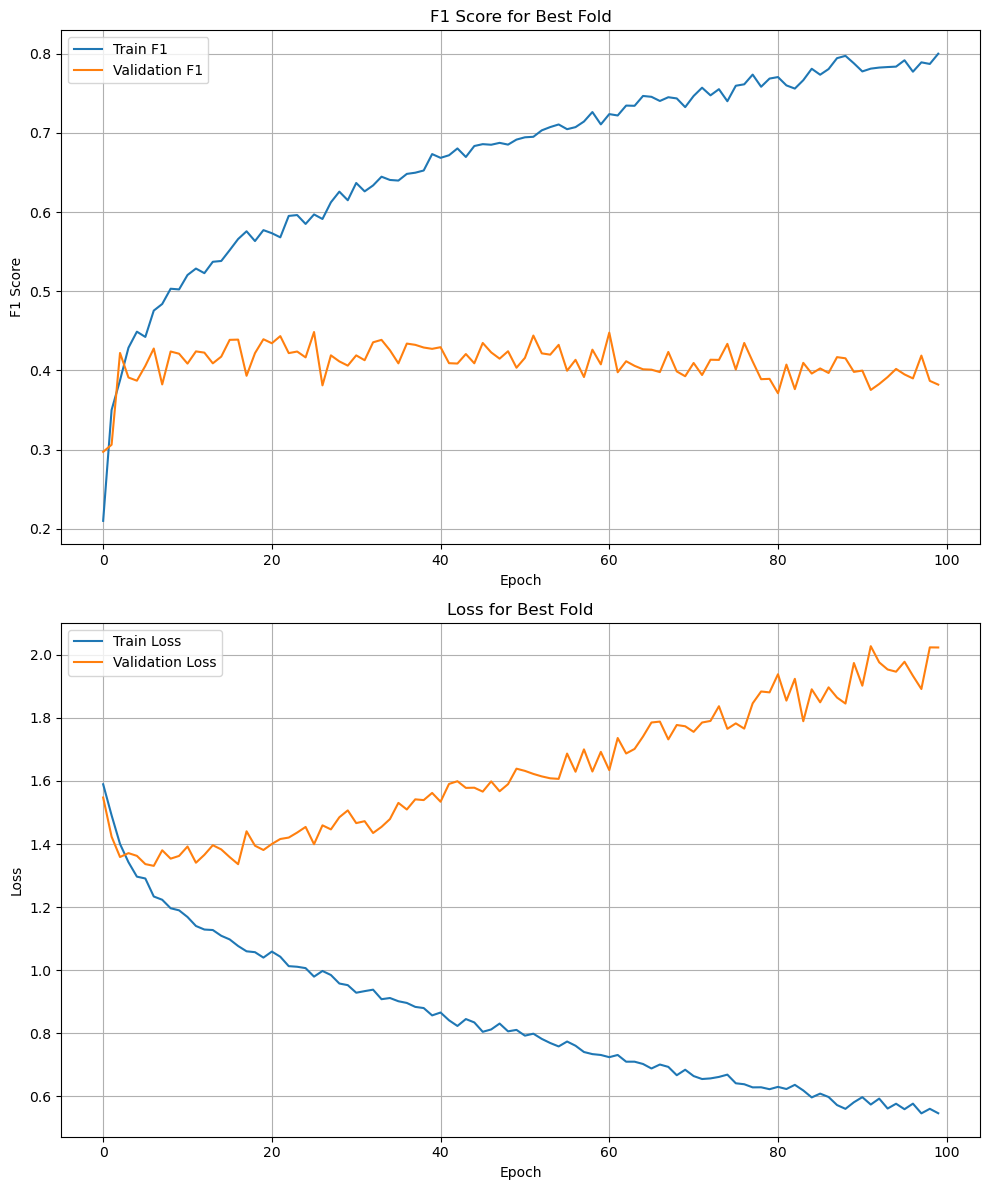

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(2688,)
              precision    recall  f1-score   support

        ADHD       0.88      0.81      0.84       528
     HEALTHY       0.83      0.84      0.83       540
         MDD       0.74      0.65      0.69       540
         OCD       0.74      0.81      0.77       540
         SMC       0.81      0.87      0.84       540

    accuracy                           0.80      2688
   macro avg       0.80      0.80      0.80      2688
weighted avg       0.80      0.80      0.80      2688



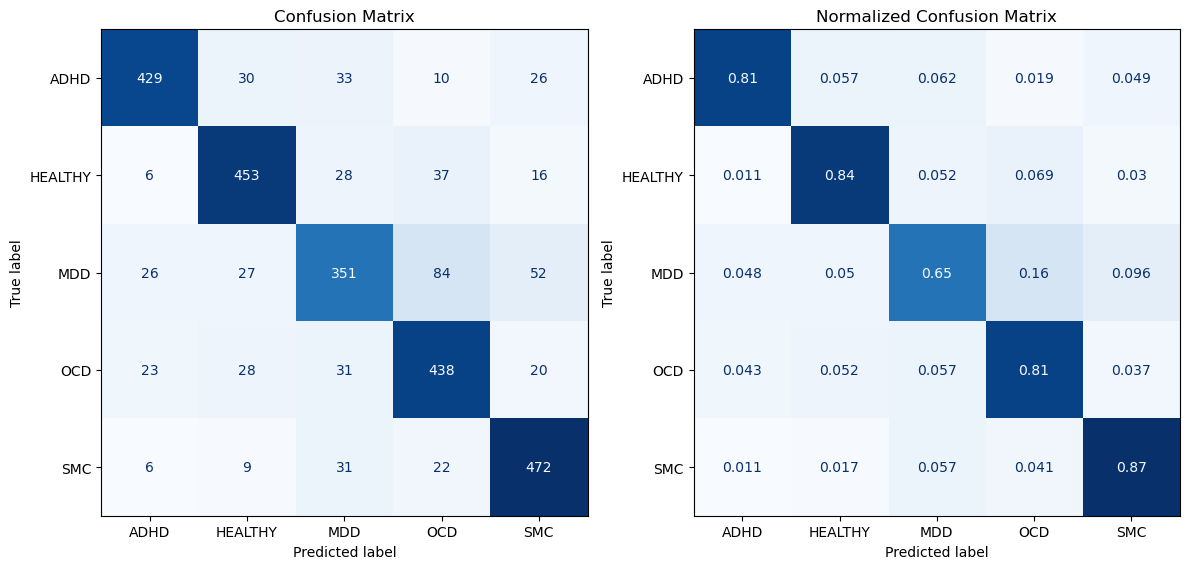

In [9]:
# evaluate tuning results
print(f'Test f1-scores: {test_scores}')
print(f'Average test f1-scores: {np.mean(test_scores)}')
print(f'Std of test f1-scores: {np.std(test_scores)}')
print(f'Best fold test f1-score: {np.max(test_scores)}')

evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path)

#### 1b. Tpos = 2

In [10]:
%%capture 
# cannot suppress output from pytorch lightning
# perform nested cross-validation with hyperparameter optimization
test_scores, best_outer_hyperparameters, checkpoints_path = pipeline_tuning(
    n_epochs=100,
    n_trials=50,
    dataset=dataset,
    pretext_task='fullytrained_withinRP_tpos2_ShallowNet_pretext_model'
)

[I 2024-11-04 06:12:12,802] A new study created in memory with name: no-name-6ae64696-8885-4548-bc47-365e4501c527
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2024-11-04 06:14:04,671] Trial 0 finished with value: 0.3330819110075633 and parameters: {'learning_rate': 3.0457398242386188e-05, 'fc_l

Test f1-scores: [0.3141648769378662, 0.3877068758010864, 0.2893301546573639, 0.2955072224140167, 0.3748472034931183]
Average test f1-scores: 0.33231126666069033
Std of test f1-scores: 0.04101020496455499
Best fold test f1-score: 0.3877068758010864
Best fold: 1
Best hyperparameters: {'learning_rate': 0.0020978609196799954, 'fc_layers': 4, 'optimizer': 'Adam', 'batch_size': 700, 'dropout': 0.00014477596292106036}
Best test f1-score: 0.3877068758010864
Best model checkpoint path: logs/ShallowNetTest/version_1/checkpoints/fold-1-last.ckpt
Training curve path: logs/ShallowNetTest/version_1/metrics.csv


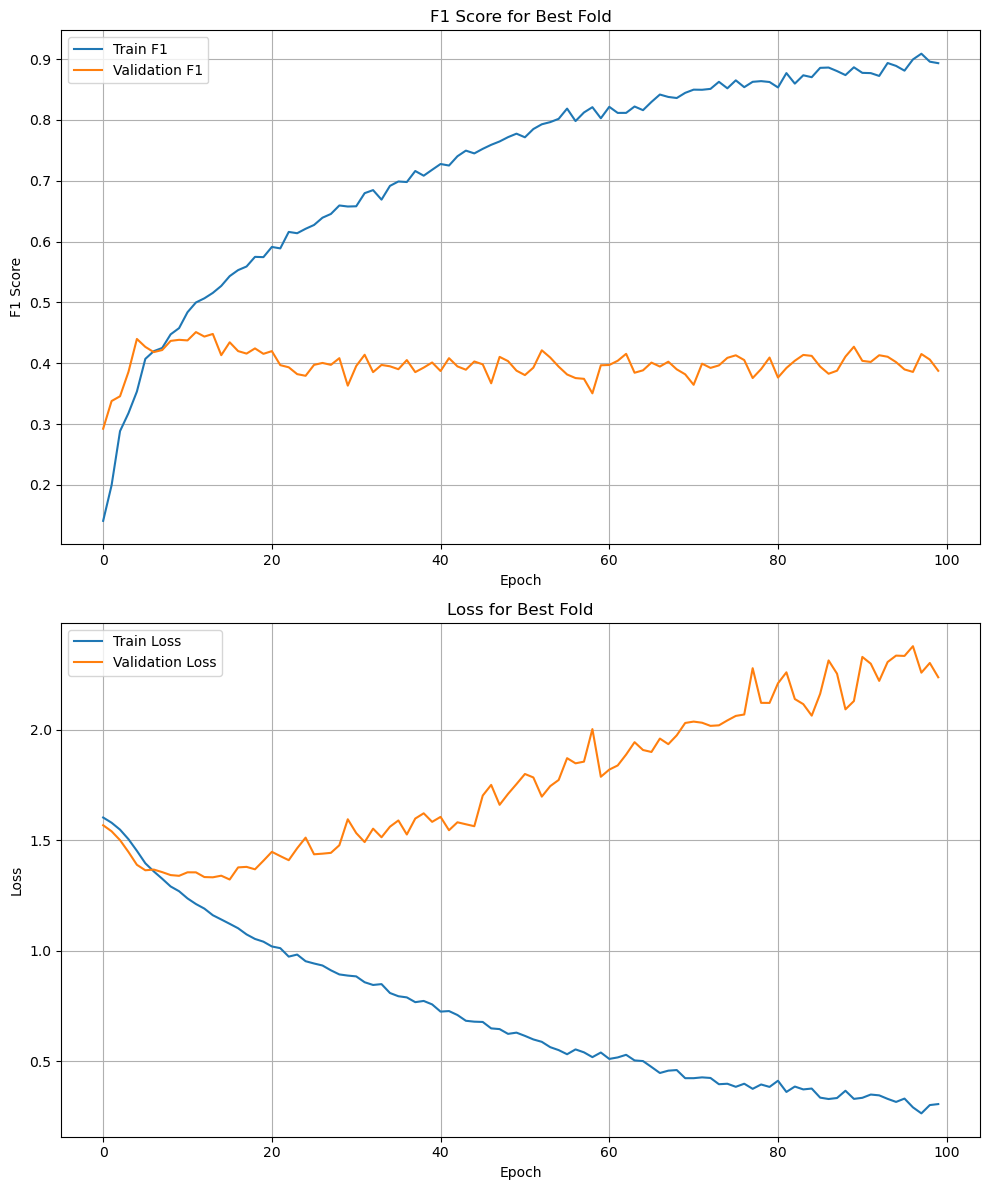

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(2688,)
              precision    recall  f1-score   support

        ADHD       0.89      0.82      0.85       528
     HEALTHY       0.86      0.84      0.85       540
         MDD       0.74      0.82      0.78       540
         OCD       0.90      0.77      0.83       540
         SMC       0.81      0.92      0.86       540

    accuracy                           0.83      2688
   macro avg       0.84      0.83      0.83      2688
weighted avg       0.84      0.83      0.83      2688



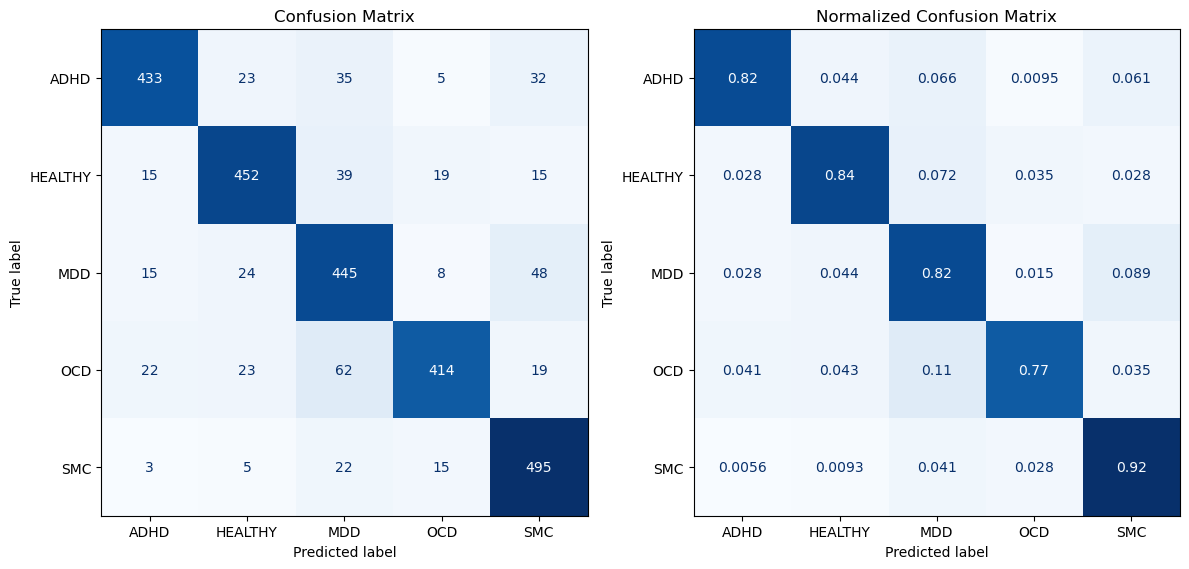

In [11]:
# evaluate tuning results
print(f'Test f1-scores: {test_scores}')
print(f'Average test f1-scores: {np.mean(test_scores)}')
print(f'Std of test f1-scores: {np.std(test_scores)}')
print(f'Best fold test f1-score: {np.max(test_scores)}')

evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path)

#### 1c. Tpos = 4

In [12]:
%%capture 
# cannot suppress output from pytorch lightning
# perform nested cross-validation with hyperparameter optimization
test_scores, best_outer_hyperparameters, checkpoints_path = pipeline_tuning(
    n_epochs=100,
    n_trials=50,
    dataset=dataset,
    pretext_task='fullytrained_withinRP_tpos4_ShallowNet_pretext_model'
)

[I 2024-11-04 13:51:04,553] A new study created in memory with name: no-name-d2312c1a-acf4-44d9-9f58-8ba9ac7d609b
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2024-11-04 13:52:44,955] Trial 0 finished with value: 0.34288089474042255 and parameters: {'learning_rate': 3.8872268254781706e-05, 'fc_

Test f1-scores: [0.2958330512046814, 0.44037333130836487, 0.3364931046962738, 0.3371831178665161, 0.3847223222255707]
Average test f1-scores: 0.3589209854602814
Std of test f1-scores: 0.0495092431668253
Best fold test f1-score: 0.44037333130836487
Best fold: 1
Best hyperparameters: {'learning_rate': 0.001264527589818969, 'fc_layers': 5, 'optimizer': 'RMSprop', 'batch_size': 350, 'dropout': 0.002964397282393488}
Best test f1-score: 0.44037333130836487
Best model checkpoint path: logs/ShallowNetTest/version_2/checkpoints/fold-1-last.ckpt
Training curve path: logs/ShallowNetTest/version_2/metrics.csv


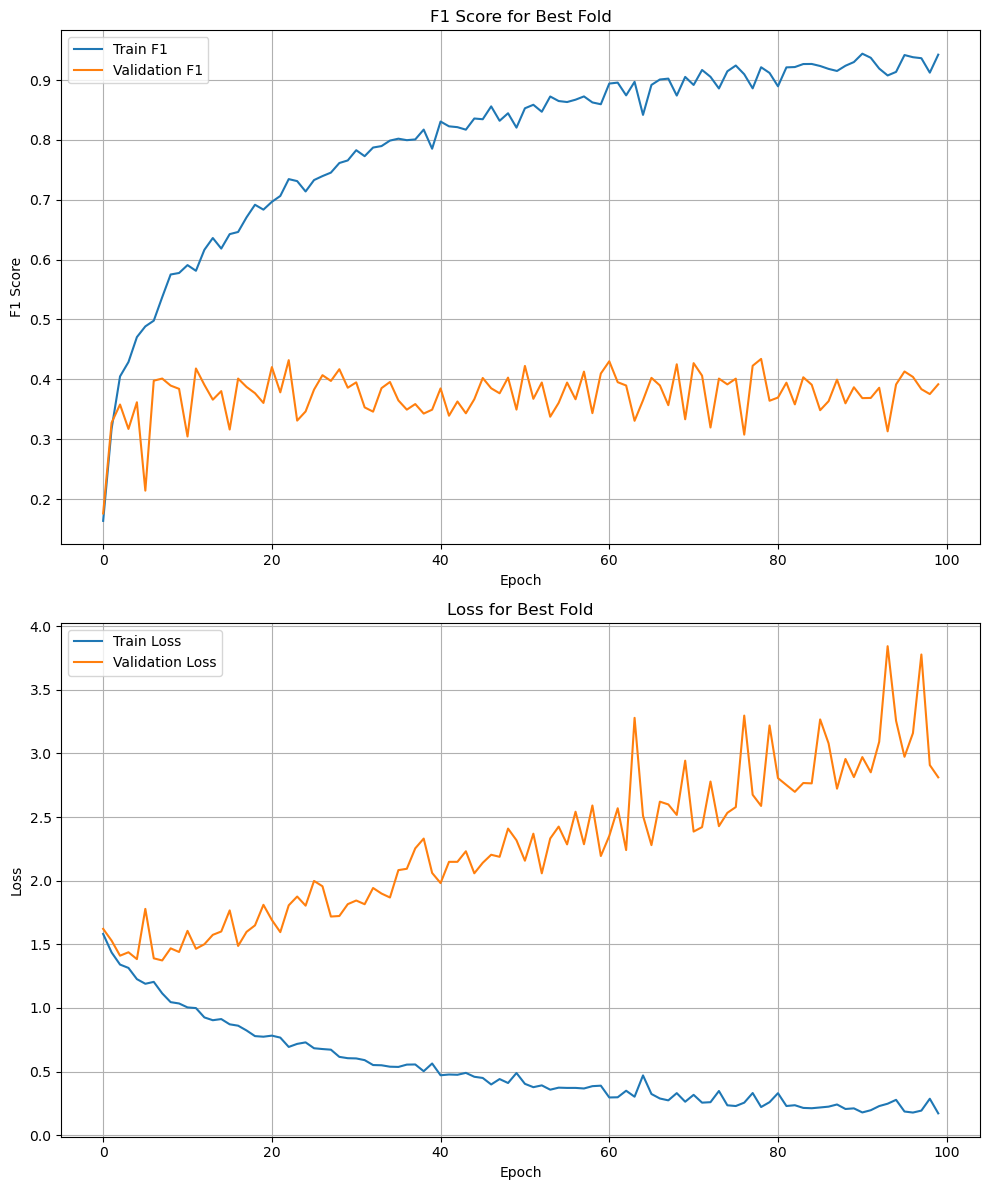

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(2688,)
              precision    recall  f1-score   support

        ADHD       0.88      0.87      0.87       528
     HEALTHY       0.91      0.78      0.84       540
         MDD       0.86      0.83      0.84       540
         OCD       0.77      0.86      0.82       540
         SMC       0.86      0.92      0.89       540

    accuracy                           0.85      2688
   macro avg       0.86      0.85      0.85      2688
weighted avg       0.86      0.85      0.85      2688



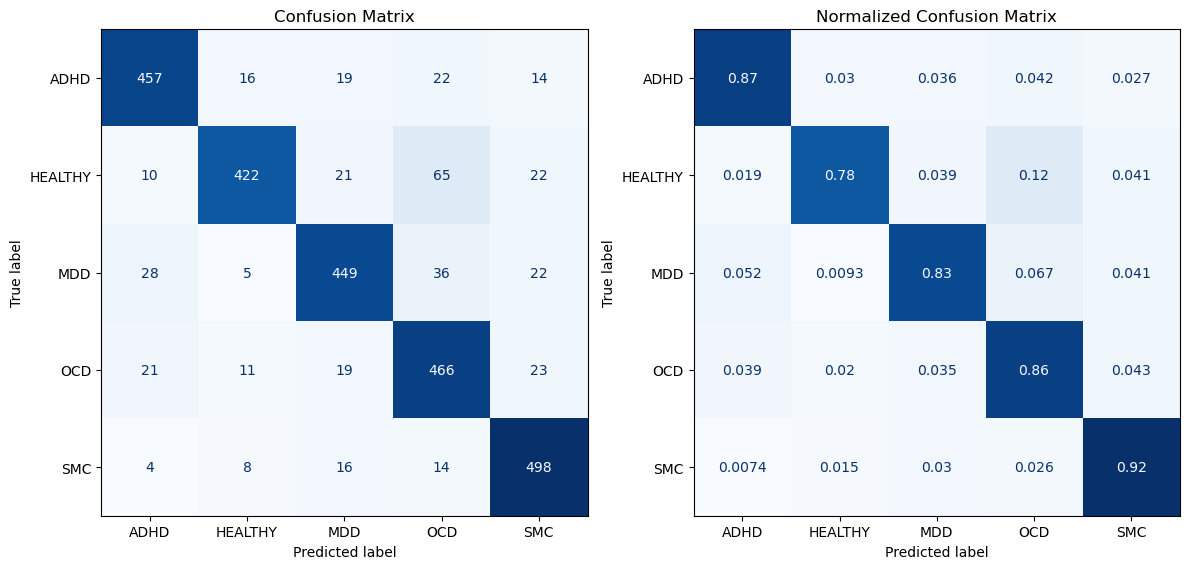

In [13]:
# evaluate tuning results
print(f'Test f1-scores: {test_scores}')
print(f'Average test f1-scores: {np.mean(test_scores)}')
print(f'Std of test f1-scores: {np.std(test_scores)}')
print(f'Best fold test f1-score: {np.max(test_scores)}')

evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path)

### 2. Across RP pretext task

#### 2a. Tpos = 1

In [14]:
%%capture 
# cannot suppress output from pytorch lightning
# perform nested cross-validation with hyperparameter optimization
test_scores, best_outer_hyperparameters, checkpoints_path = pipeline_tuning(
    n_epochs=100,
    n_trials=50,
    dataset=dataset,
    pretext_task='fullytrained_acrossRP_tpos1_ShallowNet_pretext_model'
)

[I 2024-11-04 21:24:02,987] A new study created in memory with name: no-name-e49ab290-54f6-4804-a2b1-83cc5dd9fd52
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2024-11-04 21:25:59,059] Trial 0 finished with value: 0.3156568805376689 and parameters: {'learning_rate': 0.011868925267316328, 'fc_lay

Test f1-scores: [0.298895001411438, 0.28947532176971436, 0.27298974990844727, 0.23364368081092834, 0.3471883535385132]
Average test f1-scores: 0.28843842148780824
Std of test f1-scores: 0.03688656883276023
Best fold test f1-score: 0.3471883535385132
Best fold: 4
Best hyperparameters: {'learning_rate': 0.00022251585438727543, 'fc_layers': 5, 'optimizer': 'Adam', 'batch_size': 178, 'dropout': 0.07843299912982182}
Best test f1-score: 0.3471883535385132
Best model checkpoint path: logs/ShallowNetTest/version_3/checkpoints/fold-4-last.ckpt
Training curve path: logs/ShallowNetTest/version_3/metrics.csv


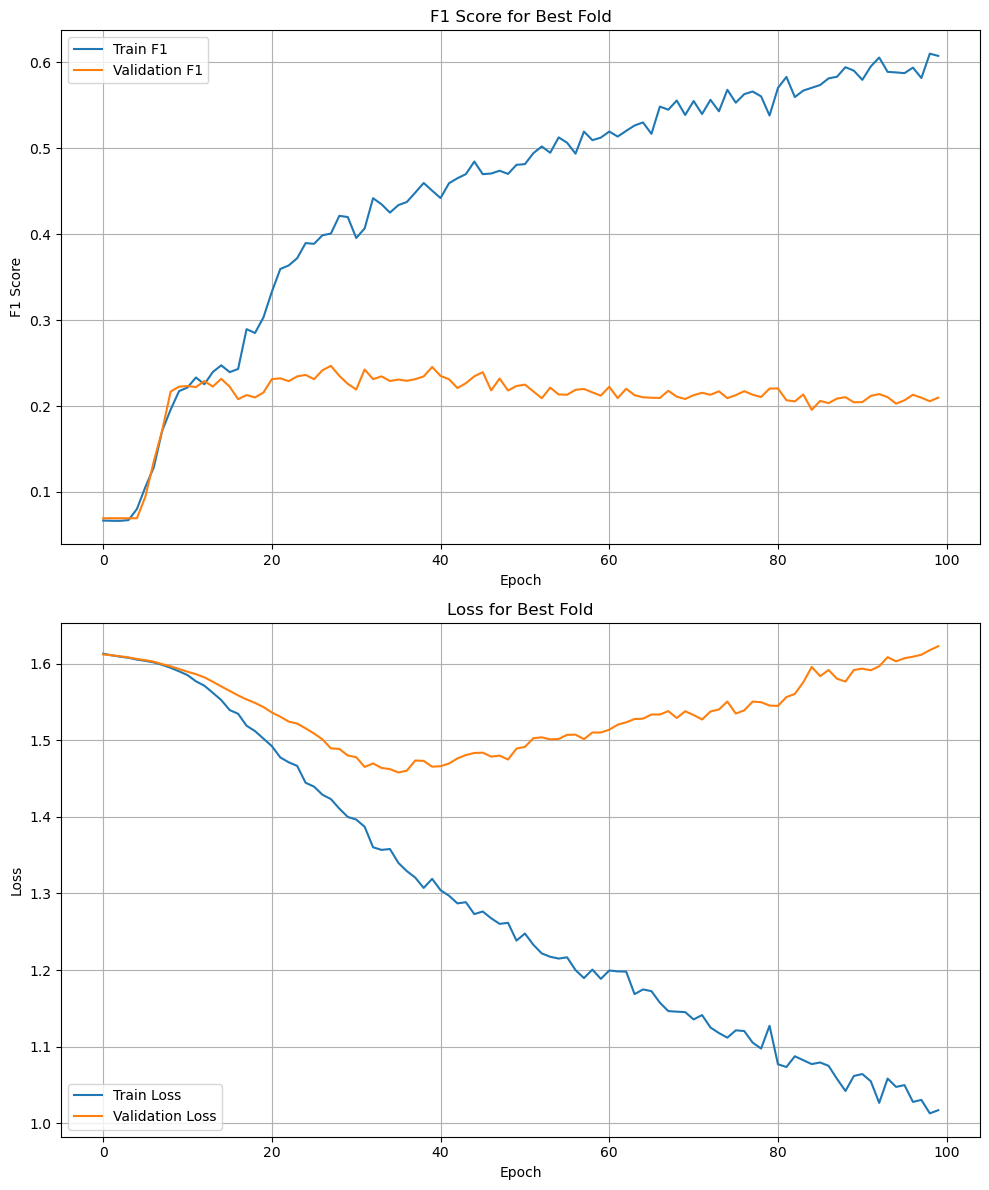

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(2688,)
              precision    recall  f1-score   support

        ADHD       0.82      0.62      0.71       528
     HEALTHY       0.74      0.60      0.66       540
         MDD       0.66      0.60      0.63       540
         OCD       0.60      0.67      0.63       540
         SMC       0.57      0.81      0.67       540

    accuracy                           0.66      2688
   macro avg       0.68      0.66      0.66      2688
weighted avg       0.68      0.66      0.66      2688



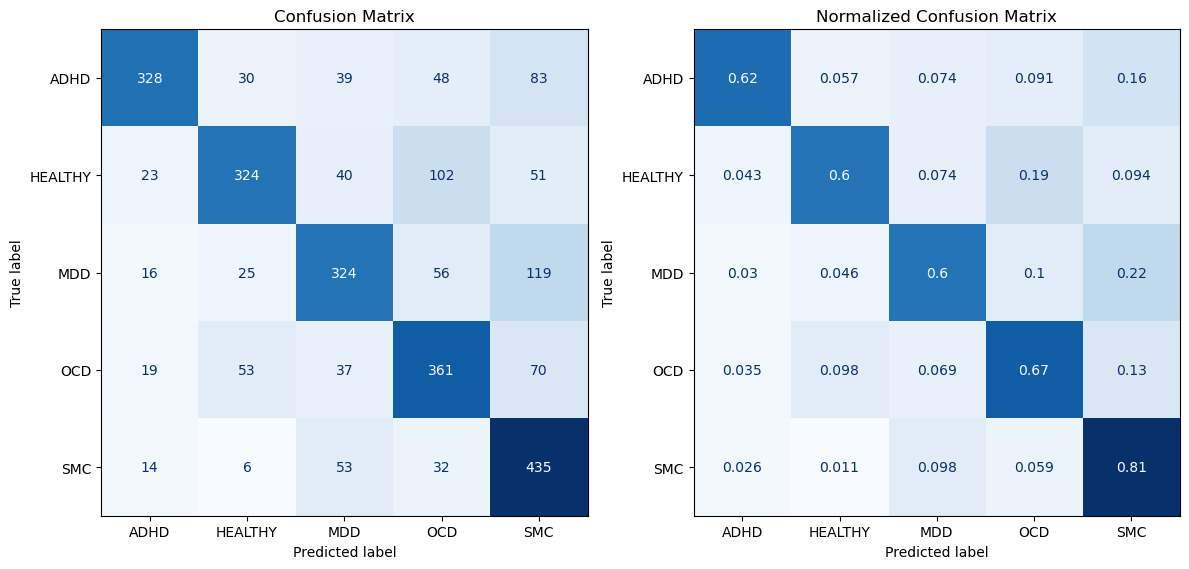

In [15]:
# evaluate tuning results
print(f'Test f1-scores: {test_scores}')
print(f'Average test f1-scores: {np.mean(test_scores)}')
print(f'Std of test f1-scores: {np.std(test_scores)}')
print(f'Best fold test f1-score: {np.max(test_scores)}')

evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path)

#### 2b. Tpos = 2

In [16]:
%%capture 
# cannot suppress output from pytorch lightning
# perform nested cross-validation with hyperparameter optimization
test_scores, best_outer_hyperparameters, checkpoints_path = pipeline_tuning(
    n_epochs=100,
    n_trials=50,
    dataset=dataset,
    pretext_task='fullytrained_acrossRP_tpos2_ShallowNet_pretext_model'
)

[I 2024-11-05 04:56:55,039] A new study created in memory with name: no-name-80ea85d6-b6a6-4034-9ddc-b36186badf93
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2024-11-05 04:58:48,328] Trial 0 finished with value: 0.0653968279560407 and parameters: {'learning_rate': 0.02261331939509623, 'fc_laye

Test f1-scores: [0.32943639159202576, 0.35158976912498474, 0.22511178255081177, 0.26796218752861023, 0.2992841899394989]
Average test f1-scores: 0.2946768641471863
Std of test f1-scores: 0.044769421431379505
Best fold test f1-score: 0.35158976912498474
Best fold: 1
Best hyperparameters: {'learning_rate': 0.0011265938167126822, 'fc_layers': 4, 'optimizer': 'Adam', 'batch_size': 476, 'dropout': 0.004707221418314872}
Best test f1-score: 0.35158976912498474
Best model checkpoint path: logs/ShallowNetTest/version_4/checkpoints/fold-1-last.ckpt
Training curve path: logs/ShallowNetTest/version_4/metrics.csv


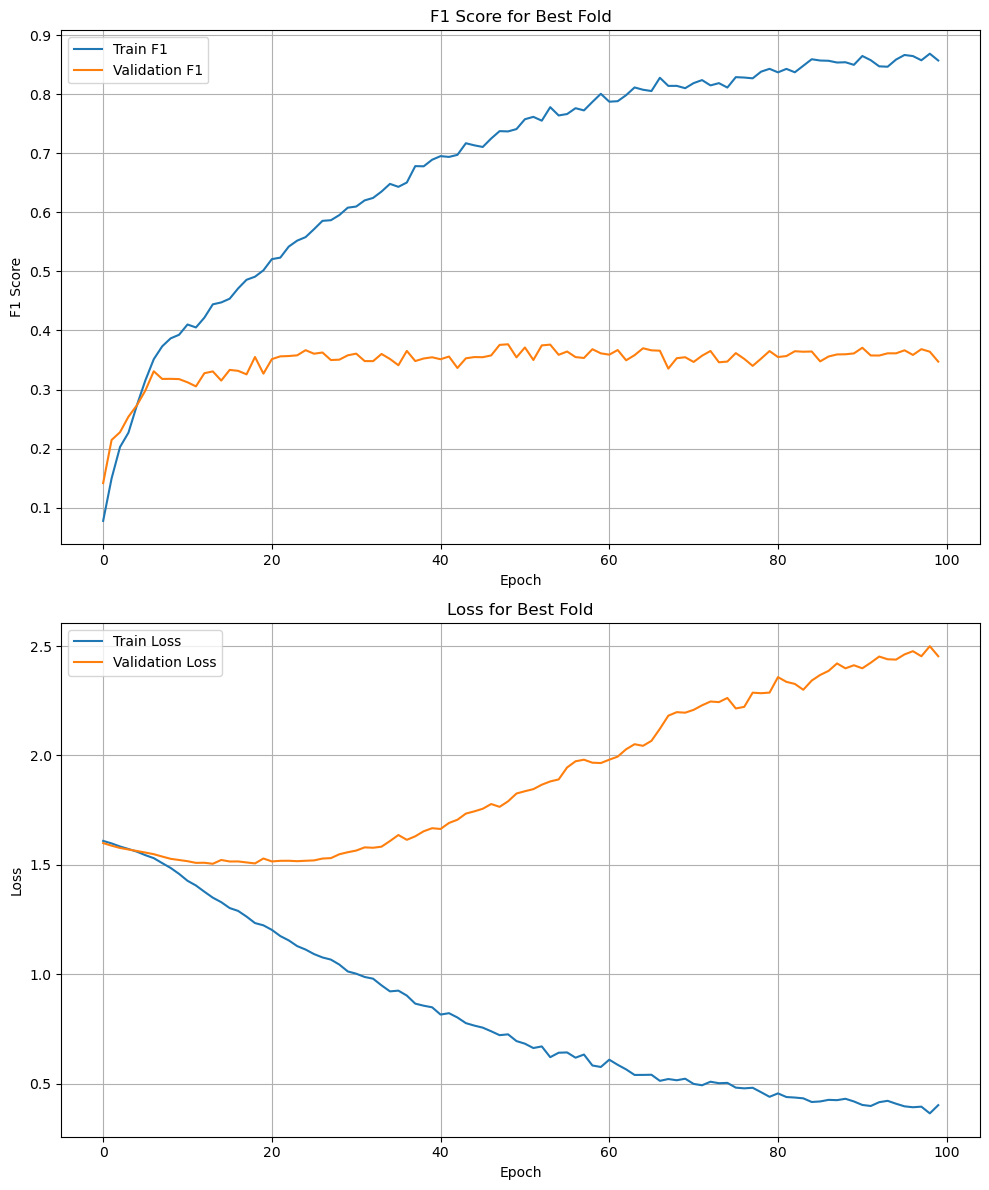

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(2688,)
              precision    recall  f1-score   support

        ADHD       0.86      0.85      0.86       528
     HEALTHY       0.88      0.84      0.86       540
         MDD       0.83      0.79      0.81       540
         OCD       0.82      0.88      0.85       540
         SMC       0.83      0.88      0.85       540

    accuracy                           0.85      2688
   macro avg       0.85      0.85      0.85      2688
weighted avg       0.85      0.85      0.85      2688



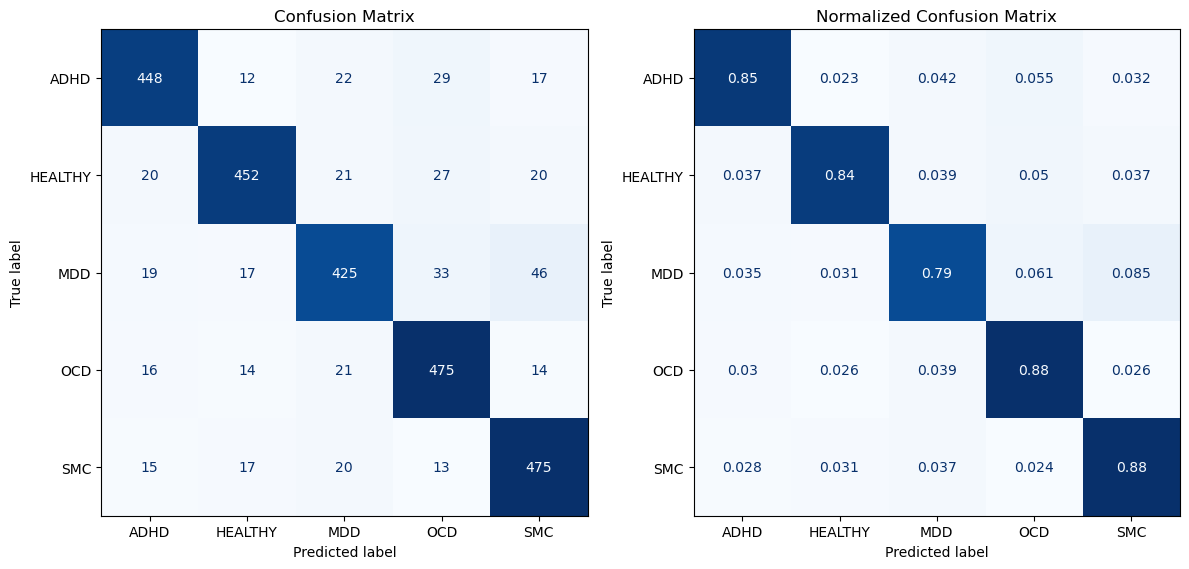

In [17]:
# evaluate tuning results
print(f'Test f1-scores: {test_scores}')
print(f'Average test f1-scores: {np.mean(test_scores)}')
print(f'Std of test f1-scores: {np.std(test_scores)}')
print(f'Best fold test f1-score: {np.max(test_scores)}')

evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path)

#### 2c. Tpos = 4

In [18]:
%%capture 
# cannot suppress output from pytorch lightning
# perform nested cross-validation with hyperparameter optimization
test_scores, best_outer_hyperparameters, checkpoints_path = pipeline_tuning(
    n_epochs=100,
    n_trials=50,
    dataset=dataset,
    pretext_task='fullytrained_acrossRP_tpos4_ShallowNet_pretext_model'
)

[I 2024-11-05 12:37:45,633] A new study created in memory with name: no-name-573d57fe-a207-4fde-abdd-51d196026489
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2024-11-05 12:39:36,975] Trial 0 finished with value: 0.23043433328469595 and parameters: {'learning_rate': 1.3479883587685955e-05, 'fc_

Test f1-scores: [0.27044686675071716, 0.3230736255645752, 0.27994218468666077, 0.3032205104827881, 0.28824561834335327]
Average test f1-scores: 0.2929857611656189
Std of test f1-scores: 0.01849667689321123
Best fold test f1-score: 0.3230736255645752
Best fold: 1
Best hyperparameters: {'learning_rate': 0.0004110746678820882, 'fc_layers': 5, 'optimizer': 'Adam', 'batch_size': 50, 'dropout': 0.00817743226423276}
Best test f1-score: 0.3230736255645752
Best model checkpoint path: logs/ShallowNetTest/version_5/checkpoints/fold-1-last.ckpt
Training curve path: logs/ShallowNetTest/version_5/metrics.csv


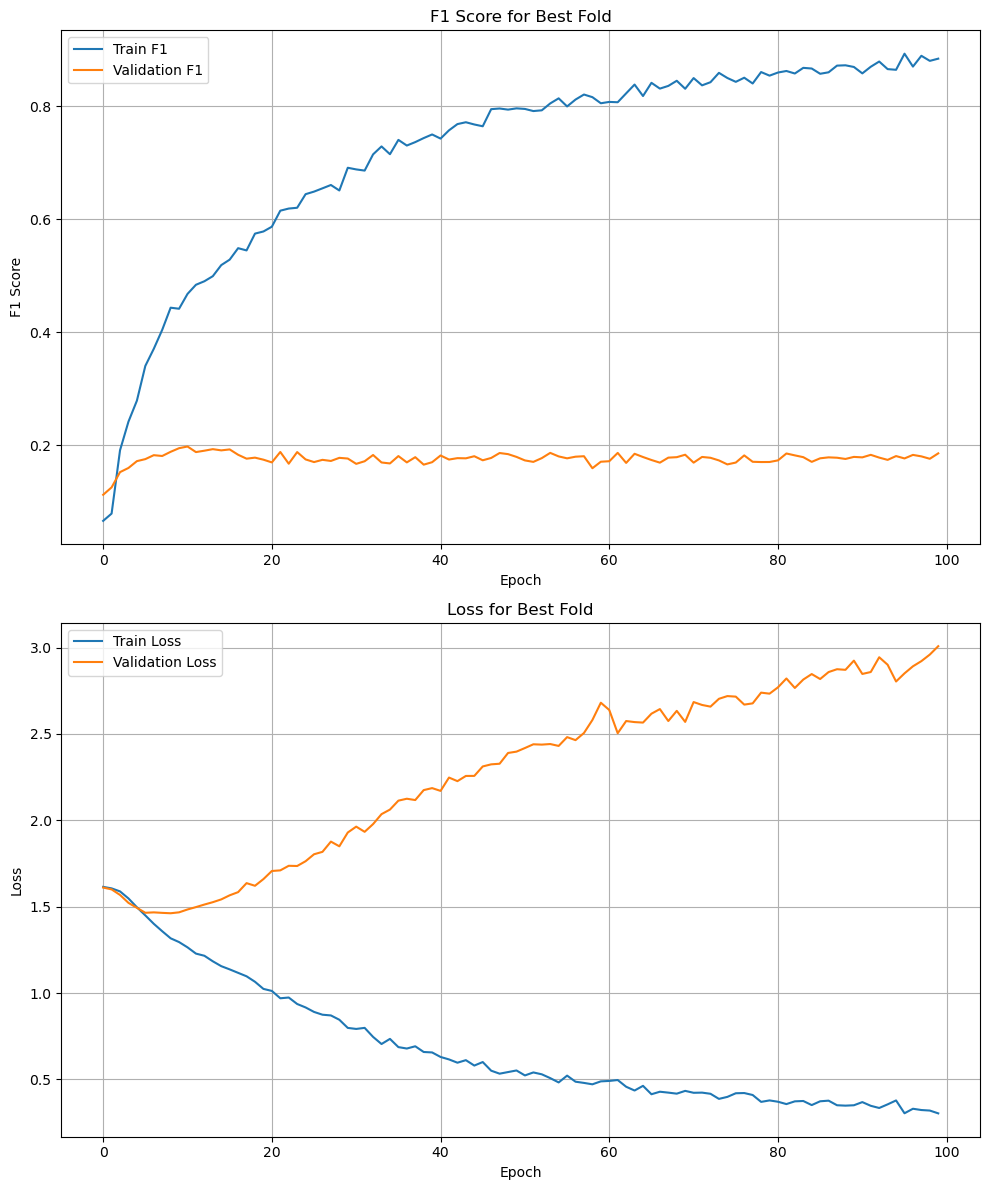

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(2688,)
              precision    recall  f1-score   support

        ADHD       0.89      0.87      0.88       528
     HEALTHY       0.91      0.84      0.87       540
         MDD       0.83      0.85      0.84       540
         OCD       0.84      0.88      0.86       540
         SMC       0.84      0.87      0.86       540

    accuracy                           0.86      2688
   macro avg       0.86      0.86      0.86      2688
weighted avg       0.86      0.86      0.86      2688



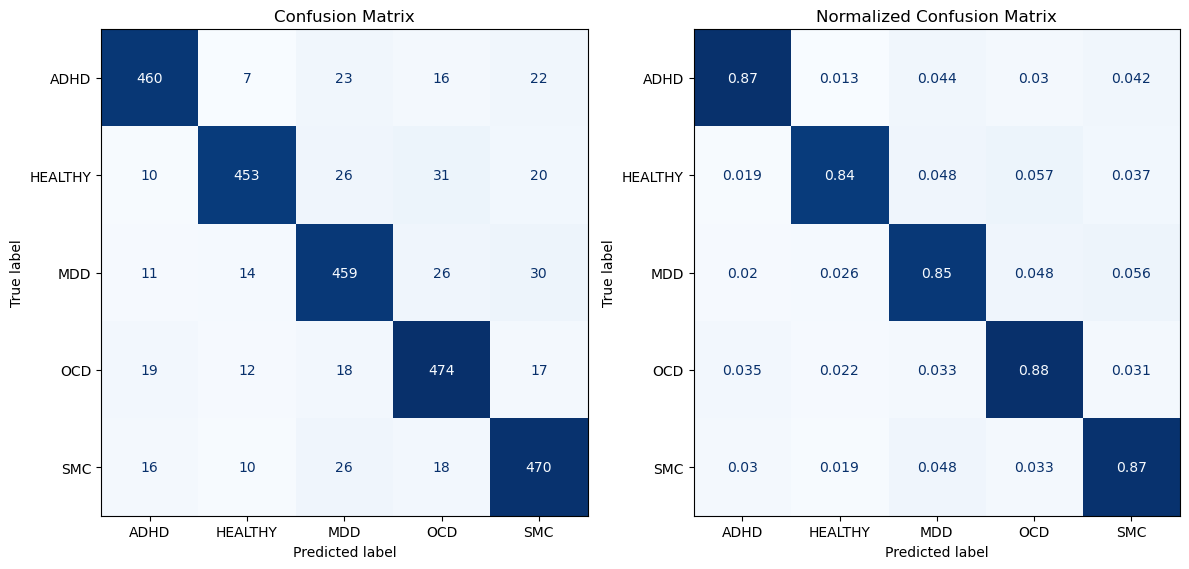

In [19]:
# evaluate tuning results
print(f'Test f1-scores: {test_scores}')
print(f'Average test f1-scores: {np.mean(test_scores)}')
print(f'Std of test f1-scores: {np.std(test_scores)}')
print(f'Best fold test f1-score: {np.max(test_scores)}')

evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path)

### 3. Across Subject pretext task

In [20]:
%%capture 
# cannot suppress output from pytorch lightning so using capture cell magic to atleast suppress a part of the output
# perform nested cross-validation with hyperparameter optimization
test_scores, best_outer_hyperparameters, checkpoints_path = pipeline_tuning(
    n_epochs=100,
    n_trials=50,
    dataset=dataset,
    pretext_task='fullytrained_acrossSub_ShallowNet_pretext_model'
)

[I 2024-11-05 20:06:40,145] A new study created in memory with name: no-name-31d5f5d6-2bed-4f43-a8d3-a89618490622
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2024-11-05 20:08:21,357] Trial 0 finished with value: 0.4592343469460805 and parameters: {'learning_rate': 0.009768969020845179, 'fc_lay

Test f1-scores: [0.2625272870063782, 0.4889785349369049, 0.32307615876197815, 0.3594975471496582, 0.41849952936172485]
Average test f1-scores: 0.37051581144332885
Std of test f1-scores: 0.07793497064531417
Best fold test f1-score: 0.4889785349369049
Best fold: 1
Best hyperparameters: {'learning_rate': 0.002668594587687396, 'fc_layers': 4, 'optimizer': 'Adam', 'batch_size': 178, 'dropout': 0.0002883493476588325}
Best test f1-score: 0.4889785349369049
Best model checkpoint path: logs/ShallowNetTest/version_6/checkpoints/fold-1-last.ckpt
Training curve path: logs/ShallowNetTest/version_6/metrics.csv


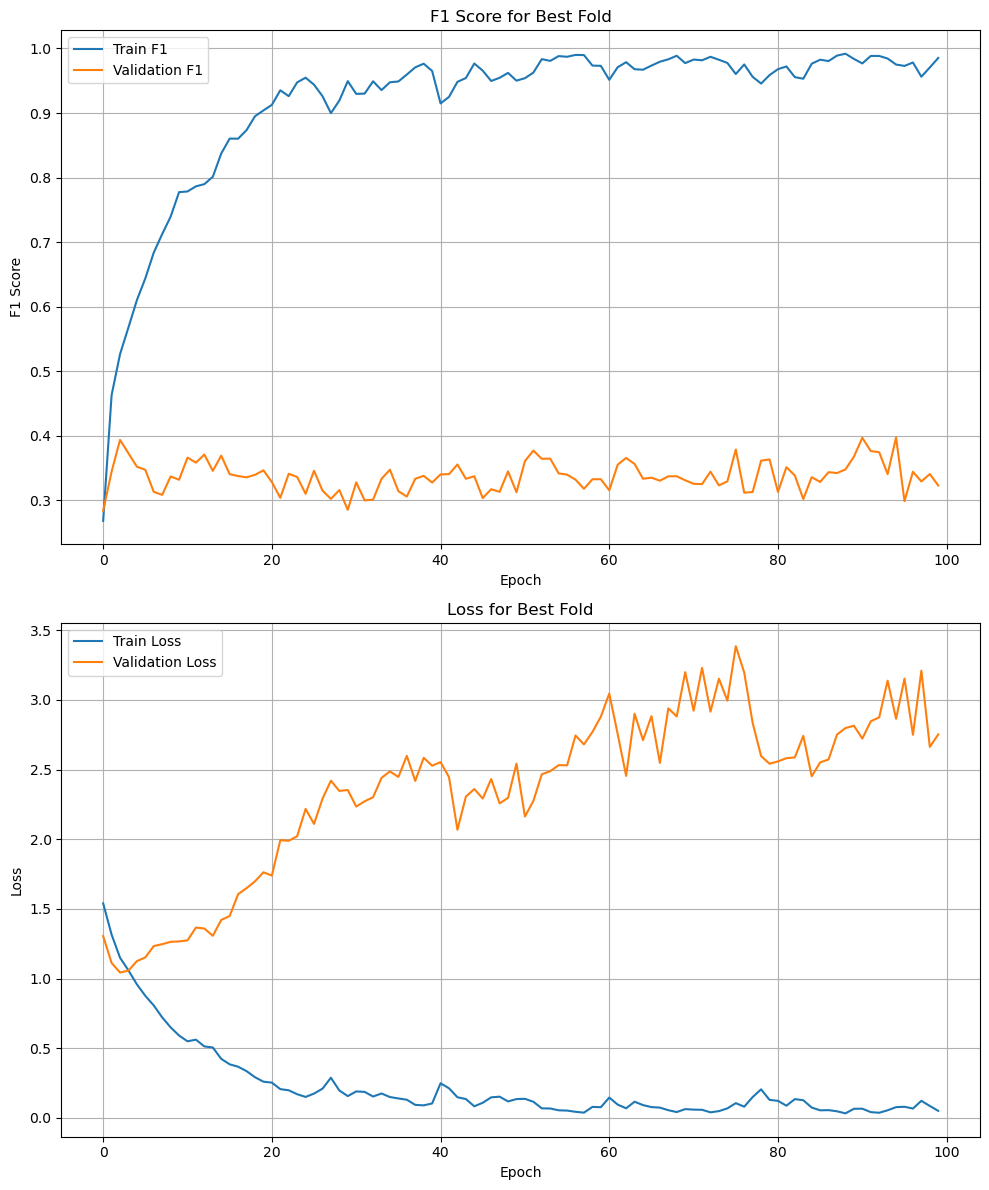

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(2688,)
              precision    recall  f1-score   support

        ADHD       0.91      0.90      0.90       528
     HEALTHY       0.85      0.93      0.89       540
         MDD       0.90      0.83      0.86       540
         OCD       0.93      0.88      0.90       540
         SMC       0.91      0.96      0.93       540

    accuracy                           0.90      2688
   macro avg       0.90      0.90      0.90      2688
weighted avg       0.90      0.90      0.90      2688



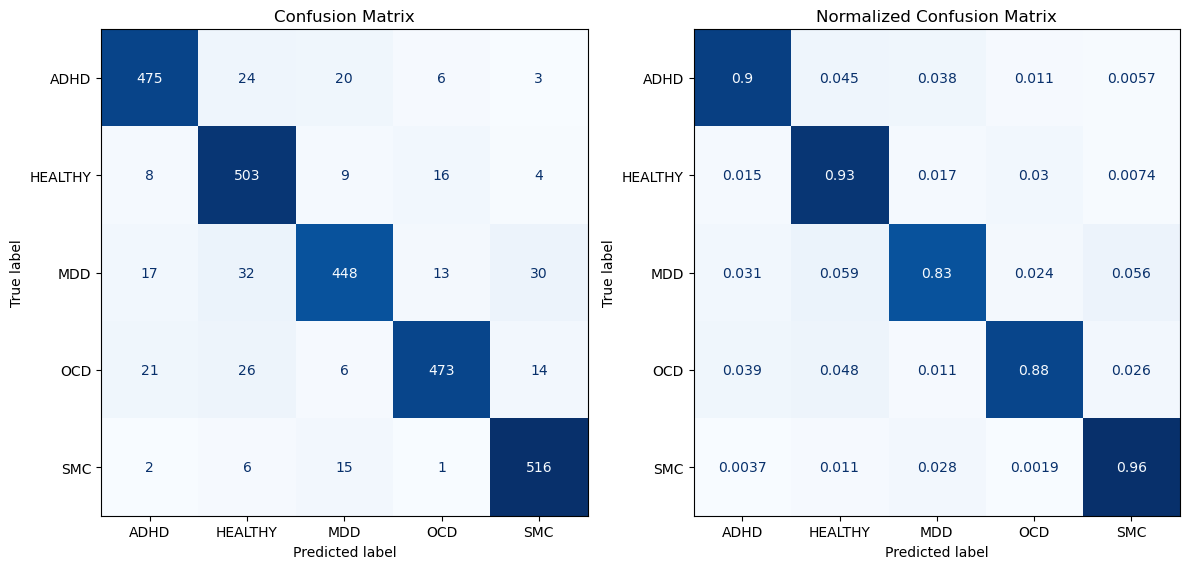

In [21]:
# evaluate tuning results
print(f'Test f1-scores: {test_scores}')
print(f'Average test f1-scores: {np.mean(test_scores)}')
print(f'Std of test f1-scores: {np.std(test_scores)}')
print(f'Best fold test f1-score: {np.max(test_scores)}')

evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path)

### 4. Contrastive loss pretext task

In [22]:
%%capture 
# cannot suppress output from pytorch lightning
# perform nested cross-validation with hyperparameter optimization
test_scores, best_outer_hyperparameters, checkpoints_path = pipeline_tuning(
    n_epochs=100,
    n_trials=50,
    dataset=dataset,
    pretext_task='fullytrained_subsaug25f_contrastive_loss_ShallowNet_pretext_model'
)

[I 2024-11-06 03:31:12,305] A new study created in memory with name: no-name-79e3fc2e-27ed-42a8-99f9-bb78718b728c
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2024-11-06 03:33:10,822] Trial 0 finished with value: 0.4521564741929372 and parameters: {'learning_rate': 0.01805027301223862, 'fc_laye

Test f1-scores: [0.3704458475112915, 0.4253987669944763, 0.28408002853393555, 0.26818525791168213, 0.34805890917778015]
Average test f1-scores: 0.3392337620258331
Std of test f1-scores: 0.057560941338385324
Best fold test f1-score: 0.4253987669944763
Best fold: 1
Best hyperparameters: {'learning_rate': 0.0034612816944249187, 'fc_layers': 5, 'optimizer': 'Adam', 'batch_size': 700, 'dropout': 0.021961970250033463}
Best test f1-score: 0.4253987669944763
Best model checkpoint path: logs/ShallowNetTest/version_7/checkpoints/fold-1-last.ckpt
Training curve path: logs/ShallowNetTest/version_7/metrics.csv


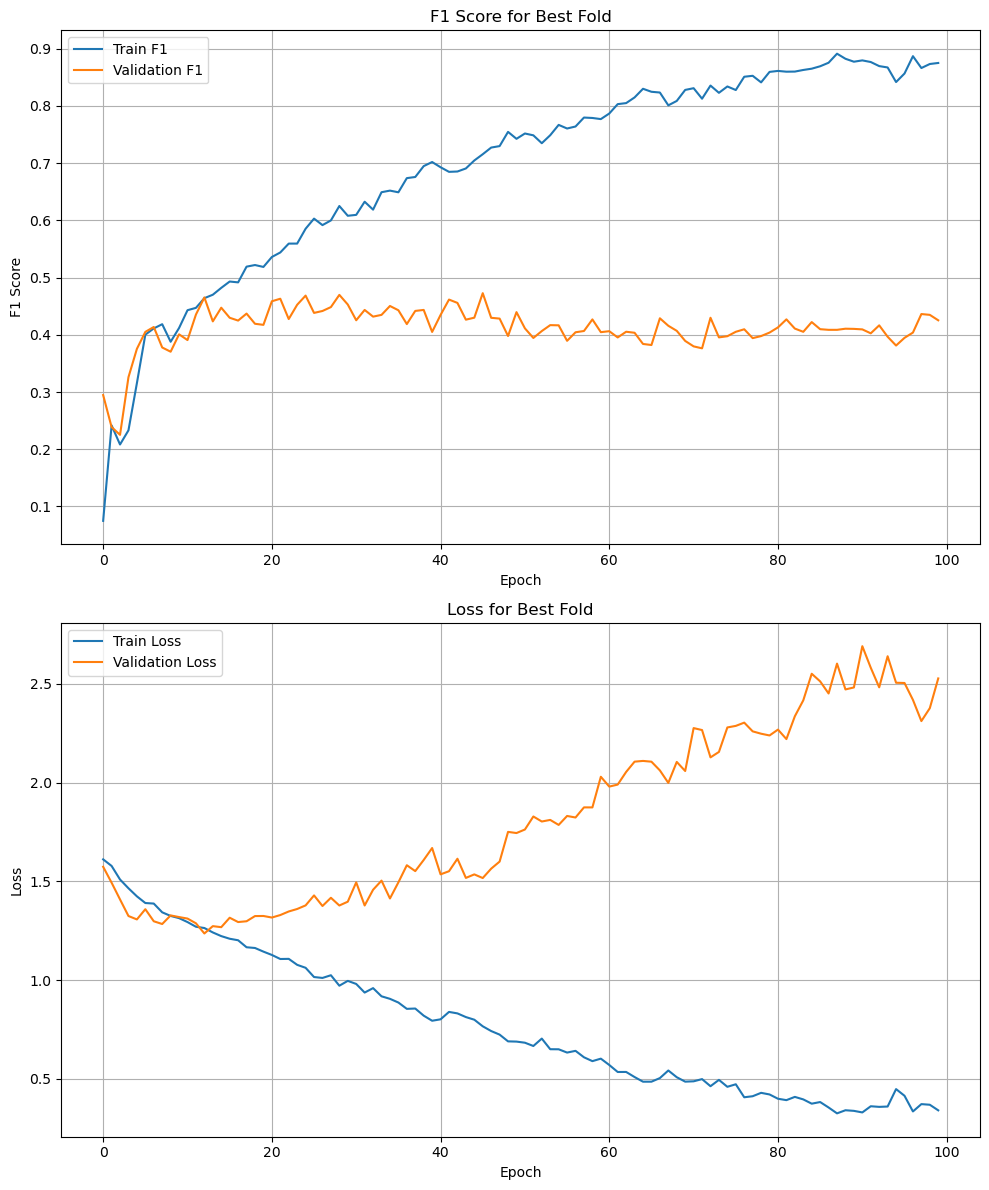

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(2688,)
              precision    recall  f1-score   support

        ADHD       0.87      0.89      0.88       528
     HEALTHY       0.89      0.82      0.85       540
         MDD       0.75      0.79      0.77       540
         OCD       0.88      0.71      0.79       540
         SMC       0.80      0.94      0.86       540

    accuracy                           0.83      2688
   macro avg       0.84      0.83      0.83      2688
weighted avg       0.84      0.83      0.83      2688



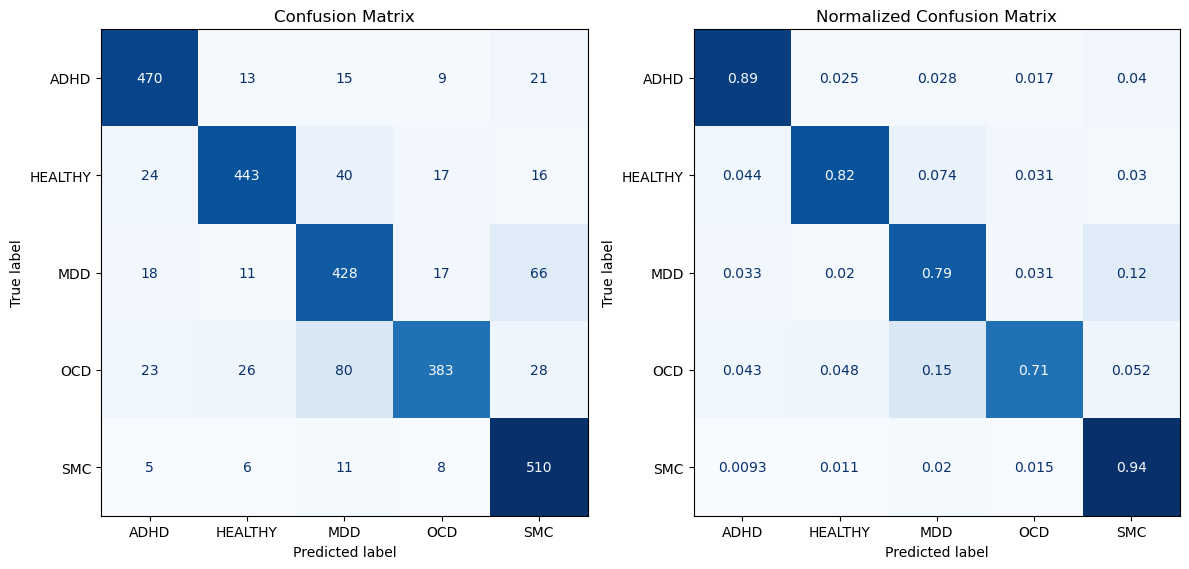

In [23]:
# evaluate tuning results
print(f'Test f1-scores: {test_scores}')
print(f'Average test f1-scores: {np.mean(test_scores)}')
print(f'Std of test f1-scores: {np.std(test_scores)}')
print(f'Best fold test f1-score: {np.max(test_scores)}')

evaluate_best_model(test_scores, best_outer_hyperparameters, checkpoints_path)